## Dependencies

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import time
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import utils.training as train_utils
from datasets.data import camvid_loaders
import models
import utils.imgs
import utils.training as train_utils

## Model Setup

In [2]:
model_cfg = getattr(models, 'FCDenseNet67')


## CamVid

Clone this repository which holds the CamVid dataset
```
git clone https://github.com/alexgkendall/SegNet-Tutorial
```

In [3]:

RESULTS_PATH = Path('.results/')
WEIGHTS_PATH = Path('.weights/')
RESULTS_PATH.mkdir(exist_ok=True)
WEIGHTS_PATH.mkdir(exist_ok=True)
batch_size = 2

In [4]:
torch.cuda.manual_seed(0)

loaders, num_classes = camvid_loaders('/home/wesley/Desktop/nfs01_tesla/CamVid/', 
                         batch_size = batch_size, num_workers =1, ft_batch_size=1, 
                    transform_train=model_cfg.transform_train, transform_test=model_cfg.transform_test, 
                    joint_transform=model_cfg.joint_transform, ft_joint_transform=model_cfg.ft_joint_transform,
                    target_transform=model_cfg.target_transform)

/home/wesley/Desktop/nfs01_tesla/CamVid/


In [5]:
print("Train: %d" %len(loaders['train'].dataset.imgs))
print("Val: %d" %len(loaders['val'].dataset.imgs))
print("Test: %d" %len(loaders['test'].dataset.imgs))
print("Classes: %d" % num_classes)

inputs, targets = next(iter(loaders['train']))
print("Inputs: ", inputs.size())
print("Targets: ", targets.size())

Train: 367
Val: 101
Test: 233
Classes: 11
Inputs:  torch.Size([2, 3, 224, 224])
Targets:  torch.Size([2, 224, 224])


In [6]:
img_means = inputs[0].mean((1,2)).unsqueeze(1).unsqueeze(2)
img_std = torch.tensor([inputs[0][i].std() for i in range(3)]).unsqueeze(1).unsqueeze(2)

normalized_input = (inputs[0] - img_means) / img_std

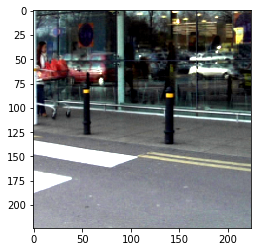

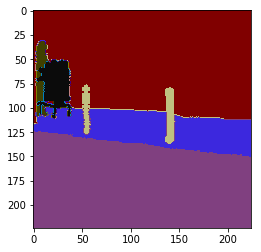

In [7]:
utils.imgs.view_image(normalized_input)
utils.imgs.view_annotated(targets[0])

## Train

In [8]:
LR = 1e-4
LR_DECAY = 0.9995
DECAY_EVERY_N_EPOCHS = 1
N_EPOCHS = 2


In [9]:
model = model_cfg.base(*model_cfg.args, num_classes=num_classes, **model_cfg.kwargs)
model.cuda()
model.apply(train_utils.weights_init)

optimizer = torch.optim.RMSprop(model.parameters(), lr=LR, weight_decay=1e-4)
criterion = train_utils.masked_ce_loss

/home/wesley/Documents/Code/pytorch_tiramisu/utils/training.py:151: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  nn.init.kaiming_uniform(m.weight)


In [10]:
for epoch in range(1, N_EPOCHS+1):
    since = time.time()

    ### Train ###
    trn_loss, trn_err = train_utils.train(
        model, loaders['train'], optimizer, criterion)
    print('Epoch {:d}\nTrain - Loss: {:.4f}, Acc: {:.4f}'.format(
        epoch, trn_loss, 1-trn_err))    
    time_elapsed = time.time() - since  
    print('Train Time {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    ### Test ###
    val_loss, val_err, val_mjacc = train_utils.test(model, loaders['val'], criterion, epoch)    
    print('Val - Loss: {:.4f} | Acc: {:.4f} | mIOU {:.4f} '.format(val_loss, 1-val_err, 1-val_mjacc))
    time_elapsed = time.time() - since  
    print('Total Time {:.0f}m {:.0f}s\n'.format(
        time_elapsed // 60, time_elapsed % 60))
    
    ### Checkpoint ###    
    train_utils.save_weights(model, epoch, val_loss, val_err)

    ### Adjust Lr ###
    train_utils.adjust_learning_rate(LR, LR_DECAY, optimizer, 
                                     epoch, DECAY_EVERY_N_EPOCHS)

Epoch 1
Train - Loss: 1.2403, Acc: 0.6077
Train Time 0m 28s
Val - Loss: 1.9228 | Acc: 0.1222 | mIOU 0.0774 
Total Time 0m 35s

Epoch 2
Train - Loss: 1.0584, Acc: 0.6582
Train Time 0m 28s
Val - Loss: 1.5400 | Acc: 0.1737 | mIOU 0.4474 
Total Time 0m 35s



## Test

In [11]:
train_utils.test(model, loaders['test'], criterion)  

(1.5057145357131958, 0.46125951674495747, 0.15600884114620286)

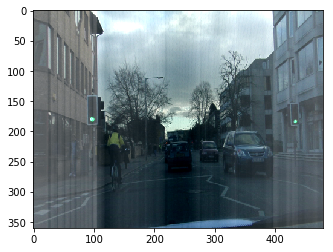

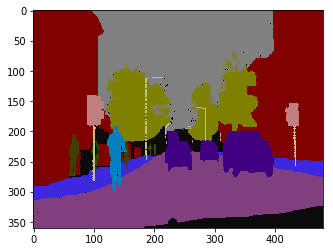

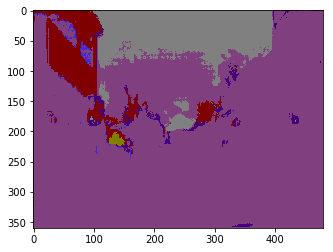

In [12]:
train_utils.view_sample_predictions(model, loaders['test'], n=1)